(nonlinearity:solution)=
### Von-May function

**Task 1**: Write a function which solves the Von-May-Equation.


**Problem description:**

<blockquote>The starting point for our analysis is the ‘Von-May-Equation’, which is given by <br>

    
**\begin{align}    
y_{t+1} = r \cdot y_{t} \cdot (1-y_{t}),
\end{align}**

with  $r$ an pre-defined parameter and $y$ the function value at time $t$ and $t+1$.</blockquote>

In [1]:
import matplotlib.pyplot as plt

def von_may(y0,r):
    '''
    This function integrates the Von-May Equationn using a then initial condition y0, 
    and the parameter r
    '''

    # Assignments
    yi = y0    
    result = [yi]

    # Integrate over 50 time steps
    for t in range(500):
        y = r*yi*(1-yi)    # Von-May-Gleichung
        yi = y             # Store new values for next step
        result.append(y)   # Append the y-value to the result list

    return(result)



**Task 2:** Run the code for several initial and parameter combination. What is particularly striking about increasing r-values?


```
y(0)=0.5 and r=2.80 (alternatively, use y(0)=0.9) 
y(0)=0.5 and r=3.30 (alternatively, use y(0)=0.9) 
y(0)=0.5 and r=3.95 (alternatively, use y(0)=0.495) 
y(0)=0.8 and r=2.80 

```

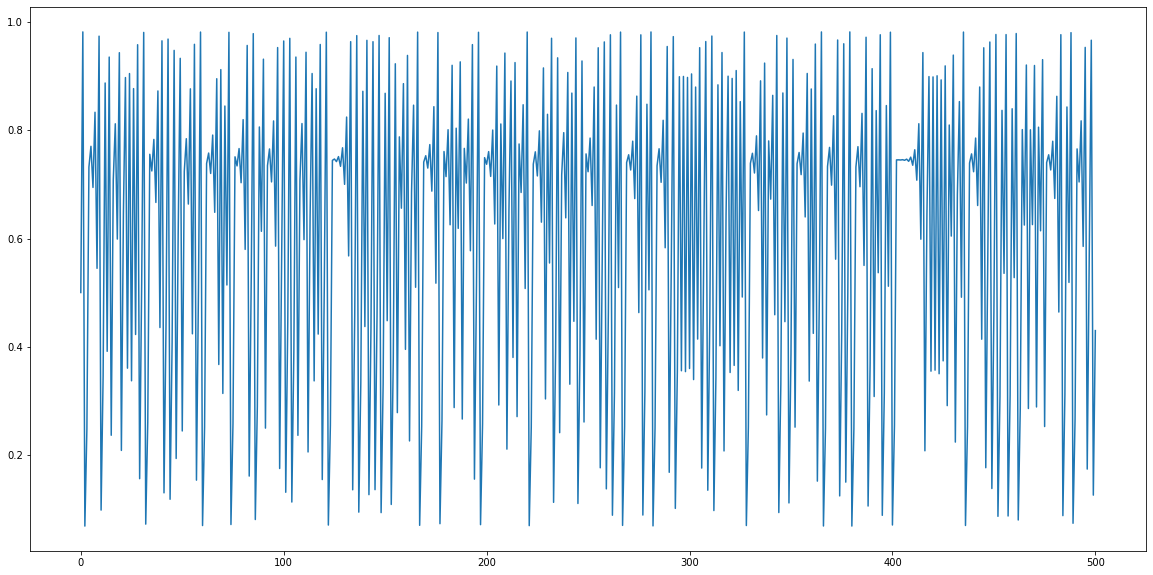

In [2]:
# Integrate the equation
res = von_may(0.5, 3.93)

# Plot the equation
plt.figure(figsize=(20,10))
plt.plot(res);

**Extend the Von-May function**

**Task 3:** Extend this Von-May function by generating 20 random r-values and run simulations with them. Sample the values from a normal distribution with mean 3.95 and standard deviation 0.015 (limit the r-values between 0 and 4). Then average over all time series. Plot both the time series, the averaged time series and the histogram of the averaged time series. What do you observe?

In [3]:
import random
import numpy as np

def ensemble_may(n, y0, r):
    '''
    The function runs n ensemble members of the Von-May-Equation. The function takes the 
    initial condition y0, the parameter r, and the number of ensemble members n.

    Example: ensemble(50, 0.5, 3.95)

    Author: Tobias Sauter
    Date:   07/04/2022

    '''

    # Assignments     
    result = []
    random.seed()
    # Generate ensemble members
    for ens_member in range(n):
        
        # Generate random parameter r
        rnd = random.normalvariate(r,0.02)
        if rnd<=0 or rnd>4:
            # set constraints for the random number 0<rnd<4
            while rnd<=0 or rnd>4:
                rnd = random.normalvariate(r,0.02);
                
        # Integrate the equation
        result.append(von_may(y0,rnd))
        
        
    return(result)



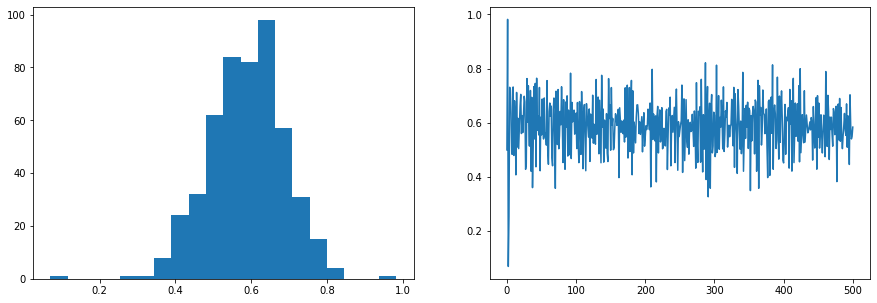

In [4]:
ens = ensemble_may(10, 0.5, 3.93)
ens_mean = np.mean(np.array(ens),axis=0)

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].hist(ens_mean, 20);
ax[1].plot(ens_mean);

**Revisit the EBM-Model**

Include a dynamic transmissivity in the energy balance model.

**Task 4:** Run the energy balance model $T(0)=288 ~ K$, $C_w= 2\cdot10^8 ~ J/(m^2 \cdot K)$, $\alpha=0.3$, and $\tau_{mean}=0.608 (\pm 10\%)$

In [5]:
import random
import numpy as np
import matplotlib.pyplot as plt


def OLR(T, tau):
    """ Stefan-Boltzmann law """
    sigma = 5.67e-8
    return tau * sigma * T**4

def ASR(Q, alpha):
    """ Absorbed shortwave radiation """
    return (1-alpha) * Q


def step_forward(Q, T, Cw, alpha, tau, dt):
        return T + dt / Cw * ( ASR(Q, alpha) - OLR(T, tau) )


In [6]:
def ebm_stochastic(T0, Q=341.3, Cw=10e8, alpha=0.3, tau=0.64, years=100):
    ''' This is a simple Energy Balance Model with global radiation and outgoing longwave radiation.'''
  
    # Create result arrays
    Ts    = np.zeros(years+1)
    Years = np.zeros(years+1)
    
    # Timestep
    dt = 60*60*24*365                  # convert days to seconds

    # Initial and boundary conditions
    Ts[0] = T0 

    # Calculation
    for n in range(years):
        tau_rnd = random.normalvariate(tau,tau*0.1)
        Years[n+1] = n+1
        Ts[n+1] = step_forward( Q, Ts[n], Cw, alpha, tau_rnd, dt )
        
    return Years, Ts
        

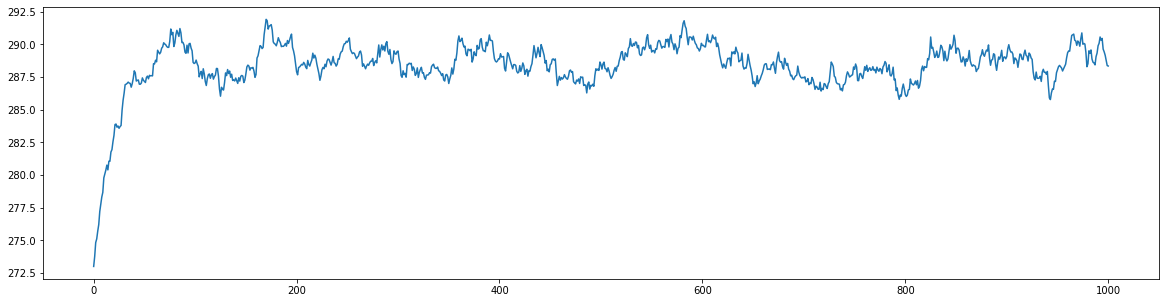

In [7]:
# Plot the results

yrs, Ts = ebm_stochastic(273, Q=342, Cw=2*10e8, alpha=0.30, tau=0.608, years=1000)
fig, ax = plt.subplots(1,1,figsize=(20,5))
ax.plot(yrs,Ts);

**Extend the model with a simple ice/land use albedo parameterisation. (sigmoid version)**

**Task 5:** In this parameterisation, the albedo is solely a function of mean temperature. As a non-linear function we assume a sigmoid function with

\begin{align}
\alpha(T_i) = 0.3 \cdot (1-0.2 \cdot \tanh(0.5 \cdot (T_i-288))).
\end{align}

Run the energy balance model for 100 years with four different initial conditions for T(0)=286.0, 287.9, 288.0, and 293.0 K, while fixing the other parameters to $C_w$= 2$\cdot10^8$ J/(m$^2 \cdot$ K) and $\tau_{mean}$=0.608. 

What can be said about the state of equilibrium?

In [8]:
import random
import numpy as np
import matplotlib.pyplot as plt


def ebm_ice_albedo(T0, Q=341.3, Cw=10e8, alpha=0.3, tau=0.64, years=100):
    ''' This is a simple Energy Balance Model with global radiation and outgoing longwave radiation.'''
  
    # Create result arrays
    Ts    = np.zeros(years+1)
    Years = np.zeros(years+1)
    
    # Timestep
    dt = 60*60*24*365                  # convert days to seconds

    # Initial and boundary conditions
    Ts[0] = T0 

    # Calculation
    for n in range(years):
        alpha_adapt = alpha * (1 - 0.2 * np.tanh(0.5*(Ts[n]-288)))
        Years[n+1] = n+1
        Ts[n+1] = step_forward( Q, Ts[n], Cw, alpha_adapt, tau, dt )
        
        
    return Years, Ts

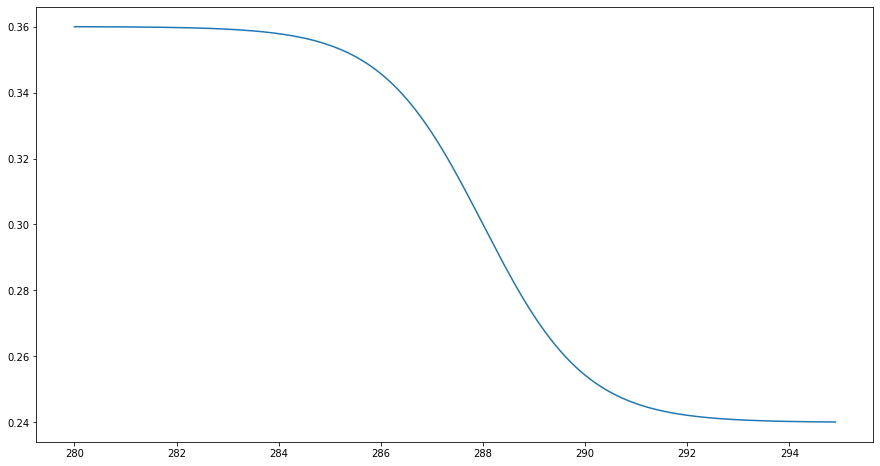

In [9]:
# Plot the albedo function
plt.figure(figsize=(15,8))
plt.plot(np.arange(280,295,0.1),0.3 * (1 - 0.2 * np.tanh(0.5*(np.arange(280,295,0.1)-288))));

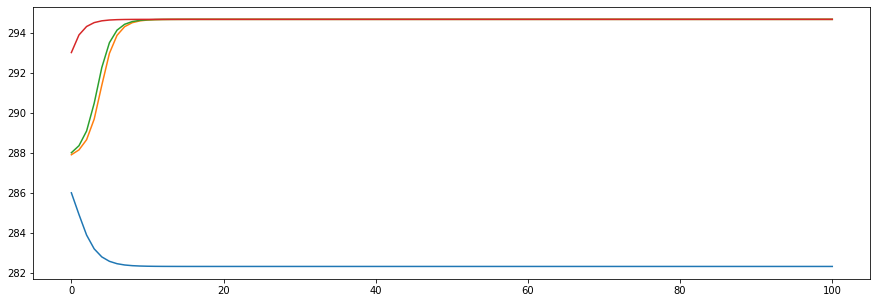

In [10]:
# Run the simulations and plot the results
yrs, Ts286 = ebm_ice_albedo(286.0, Q=342, Cw=2*10**8, alpha=0.30, tau=0.608, years=100)
yrs, Ts287 = ebm_ice_albedo(287.9, Q=342, Cw=2*10**8, alpha=0.30, tau=0.608, years=100)
yrs, Ts288 = ebm_ice_albedo(288.0, Q=342, Cw=2*10**8, alpha=0.30, tau=0.608, years=100)
yrs, Ts293 = ebm_ice_albedo(293.0, Q=342, Cw=2*10**8, alpha=0.30, tau=0.608, years=100)


fig, ax = plt.subplots(1,1,figsize=(15,5))
ax.plot(yrs, Ts286); ax.plot(yrs, Ts287); ax.plot(yrs, Ts288); ax.plot(yrs, Ts293);

**Extend the model with a simple ice/land use albedo parameterisation. (linear version)**

**Task 6:** In this parameterisation, the albedo is solely a function of mean temperature. We assume a simple linear relation according to

\begin{align}
    f(x)= 
\begin{cases}
    \alpha_i,& \text{if } T\leq T_i\\
    \alpha_g,& \text{if } T \geq T_g\\
    \alpha_g+b(T_g-T) & \text{if } T_i<T<T_g
\end{cases}
\end{align}

with $T_i$=273 K, and $T_g$= 292 K. Run the energy balance model for 100 years with four different initial conditions for T(0)=286.0, 287.9, 288.0, and 293.0 K, while fixing the other parameters to $C_w$= 2$\cdot10^8$ J/(m$^2 \cdot$ K), and $\tau_{mean}$=0.608, $a_i$=0.6, and $a_g$=0.2. 

What can be said about the state of equilibrium?

In [11]:
import random
import numpy as np
import matplotlib.pyplot as plt


def ebm_ice_albedo_2(T0, Q=341.3, Cw=10e8, alpha=0.3, tau=0.608, years=100):
    ''' This is a simple Energy Balance Model with global radiation and outgoing longwave radiation.'''
  
    # Create result arrays
    Ts    = np.zeros(years+1)
    Years = np.zeros(years+1)
    
    # Timestep
    dt = 60*60*24*365                  # convert days to seconds

    # Initial and boundary conditions
    Ts[0] = T0 
    a_i = 0.6
    a_g = 0.20
    T_i = 273
    T_g = 292
    
    # Calculation
    for n in range(years):
        if Ts[n]<=T_i:
            alpha_adapt = a_i
        elif Ts[n]>=T_g:
            alpha_adapt = a_g
        else:
            b = (a_i-a_g)/(T_g-T_i)
            alpha_adapt = a_g + b*(T_g-Ts[n])

        Years[n+1] = n+1
        Ts[n+1] = step_forward( Q, Ts[n], Cw, alpha_adapt, tau, dt )
        
        
    return Years, Ts

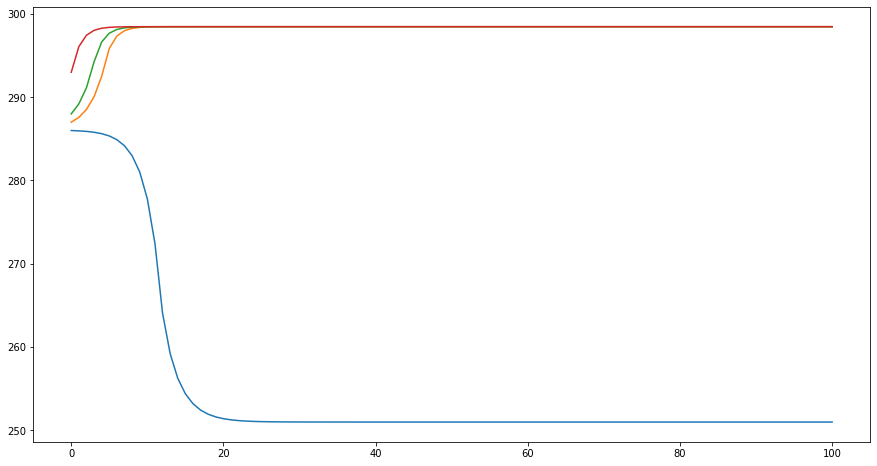

In [12]:
# Run the simulations and plot the results
yrs, Ts286 = ebm_ice_albedo_2(286, Q=342, Cw=2*10**8, alpha=0.30, tau=0.608, years=100)
yrs, Ts287 = ebm_ice_albedo_2(287, Q=342, Cw=2*10**8, alpha=0.30, tau=0.608, years=100)
yrs, Ts288 = ebm_ice_albedo_2(288, Q=342, Cw=2*10**8, alpha=0.30, tau=0.608, years=100)
yrs, Ts293 = ebm_ice_albedo_2(293, Q=342, Cw=2*10**8, alpha=0.30, tau=0.608, years=100)


fig, ax = plt.subplots(1,1,figsize=(15,8))
ax.plot(yrs, Ts286); ax.plot(yrs, Ts287); ax.plot(yrs, Ts288); ax.plot(yrs, Ts293);

**Task 7:** Determine the equilibrium climate sensitivity (ECS) and the feedback factor for the simulation from Task 5 using T(0)=289 K.  (sigmoid albedo parametrisation)

In [13]:
import random
import numpy as np
import matplotlib.pyplot as plt


def ebm_ice_albedo_stochastic_ECS(T0, Q=341.3, Cw=10e8, alpha=0.3, tau=0.64, years=100):
    ''' This is a simple Energy Balance Model with global radiation and outgoing longwave radiation.'''
      
    # Timestep
    dt = 60*60*24*365                  # convert days to seconds
    integration = int((365/10)*years)
    
    # Create result arrays
    Ts    = np.zeros(years+1)
    netQ  = np.zeros(years)
    dT    = np.zeros(years)
    Years = np.zeros(years+1)
    
    
    # Initial and boundary conditions
    Ts[0] = T0

    # Calculation
    for n in range(years):
        alpha_adapt = alpha * (1 - 0.2 * np.tanh(0.5*(Ts[n]-288)))
        
        tau_rnd = random.normalvariate(tau,tau*0.01)
        Years[n+1] = n+1
        Ts[n+1] = step_forward( Q, Ts[n], Cw, alpha_adapt, tau, dt )
        netQ[n] = ASR(Q, alpha_adapt) - OLR(Ts[n], tau)
        dT[n] = Ts[n] - Ts[0]
        
    return Years, Ts, dT, netQ

The ECS is 5.67 ºC
The feedback factor is 0.18, which implies a negative feedback


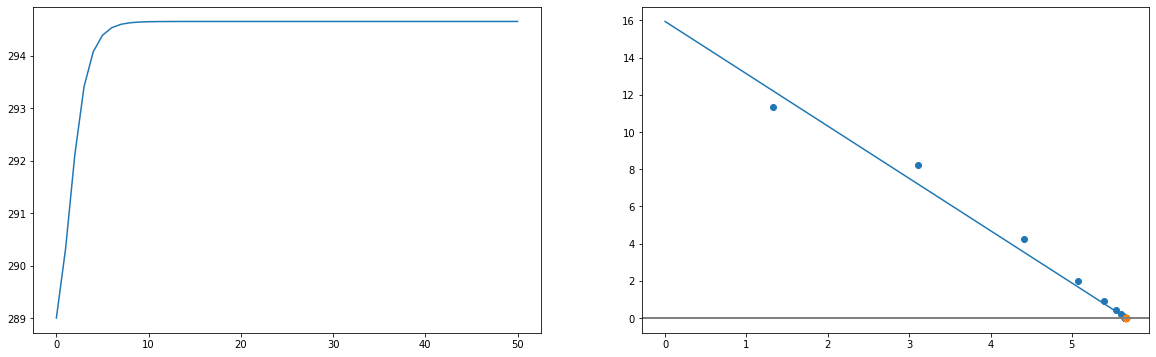

In [14]:
# Run the simulations and plot the results
yrs, Ts289, dT, netQ = ebm_ice_albedo_stochastic_ECS(289, Q=342, Cw=2*10**8, alpha=0.30, tau=0.608, years=50)


fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,6))
ax1.plot(yrs, Ts289)
ax2.scatter(dT[1:],netQ[1:])

m, b = np.polyfit(dT[1:],netQ[1:],1)
ax2.plot(np.arange(0,np.max(dT),0.1),m*np.arange(0,np.max(dT),0.1)+b)
ax2.axline((0, 0), (1, 0), linewidth=2, color='gray')
ax2.scatter(-b/m,0,s=50)

print('The ECS is {:.2f} ºC'.format(-b/m))
print('The feedback factor is {:.2f}, which implies a negative feedback'.format(-m/b))

**Task 8:** Repeat the simulation from Task 5 (sigmoid function for albedo) with T(0)=289 K, but again sample the transmissivity from a normal distribution with a standard deviation of 10%.  

What special feature can now be observed? What conclusions can be inferred regarding the prediction of weather and climate?

In [15]:
import random
import numpy as np
import matplotlib.pyplot as plt


def ebm_ice_albedo_stochastic(T0, Q=341.3, Cw=10e8, alpha=0.3, tau=0.64, years=100):
    ''' This is a simple Energy Balance Model with global radiation and outgoing longwave radiation.'''
      
    # Timestep
    dt = 60*60*24*365                  # convert days to seconds
    integration = int((365/10)*years)
    
    # Create result arrays
    Ts    = np.zeros(years+1)
    Years = np.zeros(years+1)
    
    # Initial and boundary conditions
    Ts[0] = T0 

    # Calculation
    for n in range(years):
        alpha_adapt = alpha * (1 - 0.2 * np.tanh(0.5*(Ts[n]-288)))
        
        tau_rnd = random.normalvariate(tau,tau*0.1)
        Years[n+1] = n+1
        Ts[n+1] = step_forward( Q, Ts[n], Cw, alpha_adapt, tau_rnd, dt )
        
        
    return Years, Ts

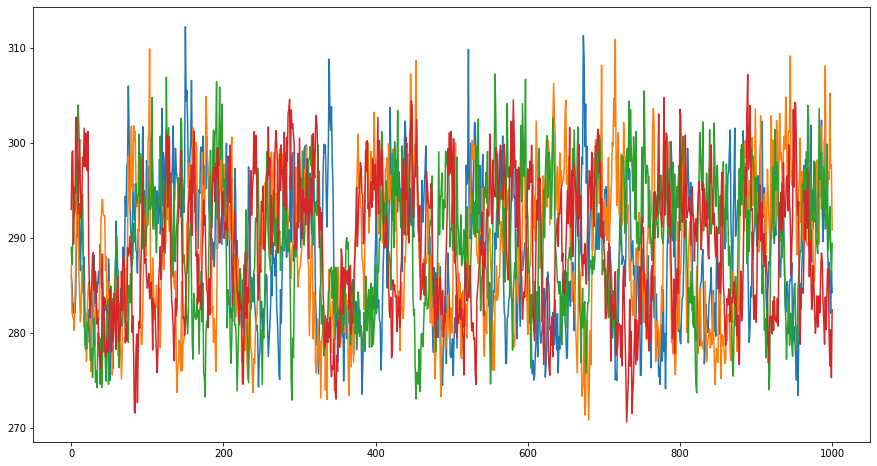

In [16]:
yrs, Ts286 = ebm_ice_albedo_stochastic(286, Q=342, Cw=2*10**8, alpha=0.30, tau=0.608, years=1000)
yrs, Ts287 = ebm_ice_albedo_stochastic(287, Q=342, Cw=2*10**8, alpha=0.30, tau=0.608, years=1000)
yrs, Ts289 = ebm_ice_albedo_stochastic(289, Q=342, Cw=2*10**8, alpha=0.30, tau=0.608, years=1000)
yrs, Ts293 = ebm_ice_albedo_stochastic(293, Q=342, Cw=2*10**8, alpha=0.30, tau=0.608, years=1000)


fig, ax = plt.subplots(1,1,figsize=(15,8))
ax.plot(yrs, Ts286); ax.plot(yrs, Ts287); ax.plot(yrs, Ts289); ax.plot(yrs, Ts293);

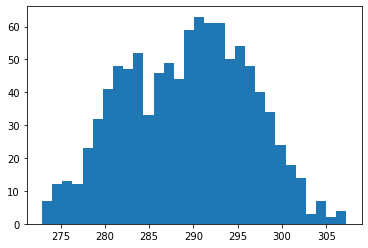

In [17]:
plt.hist(Ts289,30);